# Import libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import re
import string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras.layers.embeddings import Embedding

import spacy
from spacy.lang.pl.examples import sentences 

# Load dataset

In [2]:
data = pd.read_csv("dane treningowe_I etap.csv")

In [3]:
data.head()

,text,class
0,Wszelka korespondencja wysyłana przez Pożyczko...,KLAUZULA_ABUZYWNA
1,W przypadku opóźnień Pożyczkobiorcy w spłacie ...,KLAUZULA_ABUZYWNA
2,W przypadku opóźnień Pożyczkobiorcy w spłacie ...,KLAUZULA_ABUZYWNA
3,Pożyczkobiorca zleca firmie Narodowy Fundusz P...,KLAUZULA_ABUZYWNA
4,Od niespłaconej w terminie raty Pożyczkobiorca...,KLAUZULA_ABUZYWNA


# Explore dataset

In [4]:
data.shape[0]

4284

In [5]:
data['class'].unique()

array(['KLAUZULA_ABUZYWNA', 'BEZPIECZNE_POSTANOWIENIE_UMOWNE'],
      dtype=object)

In [6]:
len(data[data['class']=="KLAUZULA_ABUZYWNA"])

1946

In [7]:
len(data[data['class']=="BEZPIECZNE_POSTANOWIENIE_UMOWNE"])

2338

In [8]:
print(data[data['class']=="KLAUZULA_ABUZYWNA"].iloc[0]["text"])
print(data[data['class']=="KLAUZULA_ABUZYWNA"].iloc[0]["class"])

Wszelka korespondencja wysyłana przez Pożyczkodawcę na adres zamieszkania podany w umowie oraz na e-mail zostaje uznana za skutecznie doręczoną. Zmiana adresu e-mail oraz adresu zamieszkania musi być dostarczona do Pożyczkodawcy osobiście
KLAUZULA_ABUZYWNA


In [9]:
print(data[data['class']=="BEZPIECZNE_POSTANOWIENIE_UMOWNE"].iloc[0]["text"])
print(data[data['class']=="BEZPIECZNE_POSTANOWIENIE_UMOWNE"].iloc[0]["class"])

Ewentualne spory rozstrzygnę będą przez Sąd właściwy miejscowo i rzeczowo ustalony zgodnie z przepisami kodeksu postępowania cywilnego.
BEZPIECZNE_POSTANOWIENIE_UMOWNE


In [10]:
max(data["text"].str.len())

1325

# Preprocess data

In [11]:
X = data['text']
y = data['class']

In [12]:
le=LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)
print(le.transform(le.classes_))

['BEZPIECZNE_POSTANOWIENIE_UMOWNE' 'KLAUZULA_ABUZYWNA']
[0 1]


In [13]:
nlp = spacy.load("pl_core_news_md")

In [14]:
def preprocess_text(data, nlp):
    #make lowercase
    data = data.map(lambda x: x.strip().lower())
    
    # remove numbers
    alphanum_re = re.compile(r"""\w*\d\w*""")
    alphanum_lambda = lambda x: alphanum_re.sub('',x)
    data = data.map(alphanum_lambda)
    
    #removing symbols
    symb_re = re.compile('[^\w\d\s]')
    symb_lambda = lambda x: symb_re.sub(' ', x)
    data = data.map(symb_lambda)
    
    #removing underscores
    under_re = re.compile('[_]')
    under_lambda = lambda x: under_re.sub(' ', x)
    data = data.map(under_lambda)
    
    # lemmatization
    nlp = spacy.load("pl_core_news_md")
    def lemmatize(text):
        doc = nlp(text)
        return ' '.join([token.lemma_ for token in doc])
    data = data.map(lemmatize)
    
    # removing whitespace 
    data = data.map(lambda x: " ".join(x.split()))
    
    return data

In [15]:
X_prep = preprocess_text(X,nlp)

In [16]:
for i in range(len(X_prep)):
    print(i, X_prep[i])

0 wszelki korespondencja wysyłać przez pożyczkodawca na adres zamieszkanie podać w umowa oraz na e mail zostawać uznać za skutecznie doręczony zmiana adres e mail oraz adres zamieszkanie musieć być dostarczyć do pożyczkodawca osobiście
1 w przypadek opóźnień pożyczkobiorca w spłat pożyczka pożyczkodawiec mieć prawo raz dziennie telefonicznie upomnieć pożyczkobiorca do spłata pożyczka a za każdy telefon do pożyczkobiorca pożyczkodawca naliczać opłata w wysokość
2 w przypadek opóźnień pożyczkobiorca w spłat pożyczka pożyczkodawiec mieć prawo wysłać jeden wezwanie dziennie do spłata pożyczka za pomoc poczta tradycyjny oraz mailowy na adres podać w umowa a za każdy wezwanie pożyczkodawca
3 pożyczkobiorca zlecać firma narodowy fundusz pożyczkowy sp z o o poręczenie swój pożyczka i zobowiązywać się zapłacić na rzecz pożyczkodawca kwota a złoty a słownie a jeden tysiąc złoty a miesięcznie za każdy miesiąc trwać
4 od niespłacony w termin rata pożyczkobiorca zapłacić pożyczkodawca opłata karny 

In [17]:
#vectorization
def vectorize(text):
    doc = nlp(text)
    return [token.vector for token in doc]
X_vec = X_prep.map(vectorize)

In [18]:
max_length = max(X_vec.map(lambda x: len(x)))
print(max_length)

168


In [19]:
#padding
def pad(sequence):
    number_of_vec_to_add = max_length - len(sequence)
    pad_sequence = np.array((number_of_vec_to_add * [np.zeros(300)]) + sequence)
    return pad_sequence
X_pad = X_vec.map(pad)

In [20]:
X_arr = np.array(X_pad.values.tolist())

In [21]:
X_arr.shape

(4284, 168, 300)

# Split data

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_arr, y, test_size=0.3, random_state=42)

# Create Model 

In [23]:
model = Sequential()
model.add(LSTM(300,dropout=0.2, recurrent_dropout=0.2, input_shape=(X_arr.shape[1],300)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300)               721200    
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 721,501
Trainable params: 721,501
Non-trainable params: 0
_________________________________________________________________
None


# Train Model

In [24]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)

Epoch 1/10
47/47 [==============================] - 37s 752ms/step - loss: 0.5840 - accuracy: 0.6848 - val_loss: 0.4644 - val_accuracy: 0.7885
Epoch 2/10
47/47 [==============================] - 35s 744ms/step - loss: 0.4155 - accuracy: 0.8079 - val_loss: 0.4523 - val_accuracy: 0.7862
Epoch 3/10
47/47 [==============================] - 35s 743ms/step - loss: 0.3196 - accuracy: 0.8562 - val_loss: 0.4119 - val_accuracy: 0.8157
Epoch 4/10
47/47 [==============================] - 35s 742ms/step - loss: 0.2575 - accuracy: 0.8986 - val_loss: 0.4008 - val_accuracy: 0.8227
Epoch 5/10
47/47 [==============================] - 35s 756ms/step - loss: 0.1771 - accuracy: 0.9350 - val_loss: 0.4144 - val_accuracy: 0.8336
Epoch 6/10
47/47 [==============================] - 36s 766ms/step - loss: 0.1202 - accuracy: 0.9623 - val_loss: 0.4514 - val_accuracy: 0.8281
Epoch 7/10
47/47 [==============================] - 35s 745ms/step - loss: 0.1066 - accuracy: 0.9646 - val_loss: 0.4608 - val_accuracy: 0.8328

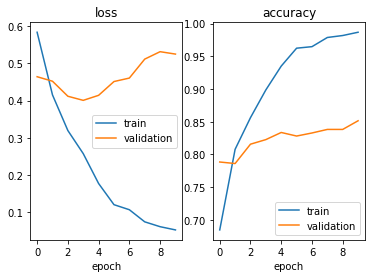

In [25]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(history.history['loss'], label = "train")
ax[0].plot(history.history['val_loss'], label = "validation")

ax[1].plot(history.history['accuracy'], label = "train")
ax[1].plot(history.history['val_accuracy'], label = "validation")

ax[0].set_xlabel("epoch")
ax[1].set_xlabel("epoch")

ax[0].set_title("loss")
ax[1].set_title("accuracy")

ax[0].legend() 
ax[1].legend() 

# Evaluate Model

In [26]:
data_test = pd.read_csv("dane testowe z klasami_I etap.csv")

In [27]:
X_test = np.array(preprocess_text(data_test["text"],nlp).map(vectorize).map(pad).values.tolist())

In [28]:
y_test = le.transform(data_test["class"])

In [29]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

In [30]:
def create_and_draw_confusion_matrix(y_test, y_pred):
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline

    cm = confusion_matrix(y_test, y_pred, labels=[1,0])
    sns.heatmap(cm, xticklabels=['predicted_positive', 'predicted_negative'], yticklabels=['actual_positive', 'actual_negative'], 
    annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");   
    return cm
def print_error_metrics(cm):
    true_pos, false_neg = cm[0]
    false_pos, true_neg = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    print('Accuracy: {}'.format(accuracy))
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1 Score: {}'.format(f1))

Accuracy: 0.8
Precision: 0.669
Recall: 0.759
F1 Score: 0.711


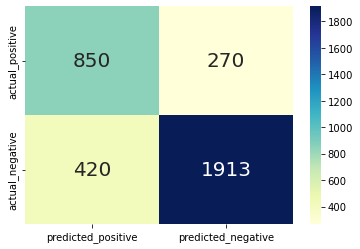

In [31]:
cm = create_and_draw_confusion_matrix(y_test, y_pred)
print_error_metrics(cm)